In [26]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.processors import TemplateProcessing

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from transformers import T5ForConditionalGeneration
from transformers import PreTrainedTokenizerFast
from transformers import Trainer, TrainingArguments

import evaluate

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [2]:
MAX_INPUT = 512
MAX_TARGET = 512

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# load dataset

In [4]:
csv_dataset = pd.read_csv("sign_language_translate/test2.csv")
csv_dataset

,sign,thai
0,โกรธ,ฉันโกรธ
1,ร้องไห้,ฉันร้องไห้
2,ดีใจ,ฉันดีใจ
3,สบายดี,ฉันสบายดี
4,เสียใจ,ฉันเสียใจ
5,หิว,ฉันหิว
6,ร้อน,ฉันร้อน
7,หนาว,ฉันหนาว
8,เครียด,ฉันเครียด
9,เศร้า,ฉันเศร้า


# make sign tokenizer

In [5]:
tokenizer_trainer = WordLevelTrainer(special_tokens=["<pad>", "</s>", "<unk>"])

In [6]:
sign_tokenizer = Tokenizer(WordLevel(unk_token="<unk>"))

In [7]:
sign_tokenizer.pre_tokenizer = Whitespace()

In [8]:
# train tokenizer
sign_tokenizer.train_from_iterator(csv_dataset["sign"].to_list(), trainer=tokenizer_trainer)

In [9]:
sign_tokenizer.enable_padding(pad_id=sign_tokenizer.token_to_id("<pad>"), pad_token="<pad>", length=MAX_TARGET)
sign_tokenizer.post_processor = TemplateProcessing(
    single="$A </s>",
    special_tokens=[
        ("</s>", sign_tokenizer.token_to_id("</s>")),
    ],
)

In [10]:
sign_tokenizer.save("sign_language_translate/sign_tokenizer.json")

# load sign tokenizer

In [12]:
sign_tokenizer = PreTrainedTokenizerFast(tokenizer_file="sign_language_translate/sign_tokenizer.json")

In [13]:
sign_vocab_size = sign_tokenizer.vocab_size
sign_vocab_size

44

In [14]:
sign_tokenizer.pad_token_id, sign_tokenizer.eos_token_id

(0, None)

In [15]:
a = sign_tokenizer.encode("สวัสดี", padding="max_length", max_length=MAX_TARGET, return_tensors="pt")

# load tokenizer (from sign2thai)

In [16]:
tokenizer = PreTrainedTokenizerFast(tokenizer_file="sign_language_translate/tokenizer-unigram.json")

In [17]:
tokenizer("สวัสดี", padding="max_length", max_length=MAX_INPUT, return_tensors="pt")

{'input_ids': tensor([[ 8, 98,  8, 28,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  

In [18]:
vocab_size = tokenizer.vocab_size
vocab_size

119

# dataset loader

In [19]:
class CustomDataset(Dataset):
    def __init__(self, csv_dataset):
        self.data = csv_dataset
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sign, thai = self.data.iloc[idx]

        tokenized_thai = tokenizer(thai, padding="max_length", max_length=MAX_INPUT, return_tensors="pt")

        thai_input, thai_attention_mask = tokenized_thai["input_ids"].squeeze(), tokenized_thai["attention_mask"].squeeze()

        sign = sign_tokenizer.encode(sign, padding="max_length", max_length=MAX_TARGET, return_tensors="pt").squeeze()

        return {
            "input_ids": thai_input,
            "attention_mask": thai_attention_mask,
            "labels": sign,
        }

In [20]:
dataset = CustomDataset(csv_dataset)

In [21]:
dataset[0]

{'input_ids': tensor([15, 40, 10, 16, 96,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0

# define model

In [22]:
model = T5ForConditionalGeneration.from_pretrained("t5-small")
model.resize_token_embeddings(vocab_size)
model.decoder.embed_tokens = nn.Embedding(sign_vocab_size, model.config.d_model)
model.lm_head = nn.Linear(model.config.d_model, sign_vocab_size, bias=False)

/home/bk/miniconda3/envs/keras/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [23]:
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(119, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(119, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Dropout(

In [25]:
training_args = TrainingArguments(
    output_dir="sign_language_translate/results/thai2sign",
    num_train_epochs=1000,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy="epoch",
    logging_dir="./logs",
    save_strategy="steps",
    save_total_limit=5,
    save_steps=100,
    save_safetensors=False,
    evaluation_strategy="steps",
    eval_steps=100,
)

In [40]:
def compute_metrics(pred):
    logits = pred.predictions[0]
    labels = pred.label_ids
    print(pred)
    print(len(pred.predictions))
    print(pred.predictions[0].shape, pred.predictions[1].shape, pred.label_ids.shape)

    predictions = logits.argmax(1)

    print(predictions)
    print(logits)

    decoded_preds = sign_tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = sign_tokenizer.batch_decode(labels, skip_special_tokens=True)

    print(decoded_preds)
    print(decoded_labels)
    
    bleu = evaluate.load("bleu")
    bleu_score = bleu.compute(predictions=decoded_preds, references=decoded_labels)["bleu"]

    return {
        "bleu": bleu_score,
    }

In [41]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    eval_dataset=dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

Step,Training Loss,Validation Loss,Bleu
100,3.428200,3.391464,0.000000
200,3.318800,3.272285,0.000000
300,3.206100,3.150496,0.000000
400,3.093700,3.031954,0.000000
500,2.983400,2.918439,0.000000
600,2.877100,2.809097,0.000000
700,2.774100,2.704178,0.000000
800,2.676400,2.603853,0.000000
900,2.576200,2.506914,0.000000
1000,2.486000,2.413420,0.000000


2
(38, 512, 44) (38, 512, 512) (38, 512)
[[145   9 115 ...   1 115   1]
 [176   2   2 ...   1   2   1]
 [263   9   1 ...   1   2   1]
 ...
 [148   3   3 ...   3   3   0]
 [178   2   3 ...   2   3   1]
 [136   2   3 ...   3   3   2]]
[[[ 0.25897524 -0.14807025 -0.06286423 ... -0.10176118 -0.06641135
   -0.092705  ]
  [ 0.2571051  -0.1471524  -0.06478096 ... -0.10112901 -0.0683922
   -0.09059972]
  [ 0.25634253 -0.14910725 -0.06438082 ... -0.10344104 -0.06650123
   -0.09486326]
  ...
  [ 0.2609484  -0.1475139  -0.0630982  ... -0.10262145 -0.06695882
   -0.09437533]
  [ 0.2609478  -0.147515   -0.06309798 ... -0.10262109 -0.06695883
   -0.09437452]
  [ 0.2609471  -0.14751613 -0.06309768 ... -0.10262068 -0.06695882
   -0.09437373]]

 [[ 0.25896925 -0.14814666 -0.06309142 ... -0.10164869 -0.0667693
   -0.09296464]
  [ 0.2548702  -0.14633873 -0.05943415 ... -0.10023661 -0.06646004
   -0.09294905]
  [ 0.25534445 -0.14508897 -0.0583934  ... -0.10108424 -0.06359087
   -0.09527189]
  ...
  [ 0.26

TrainOutput(global_step=5000, training_loss=1.6432320622444152, metrics={'train_runtime': 869.1983, 'train_samples_per_second': 43.718, 'train_steps_per_second': 5.752, 'total_flos': 5145618284544000.0, 'train_loss': 1.6432320622444152, 'epoch': 1000.0})

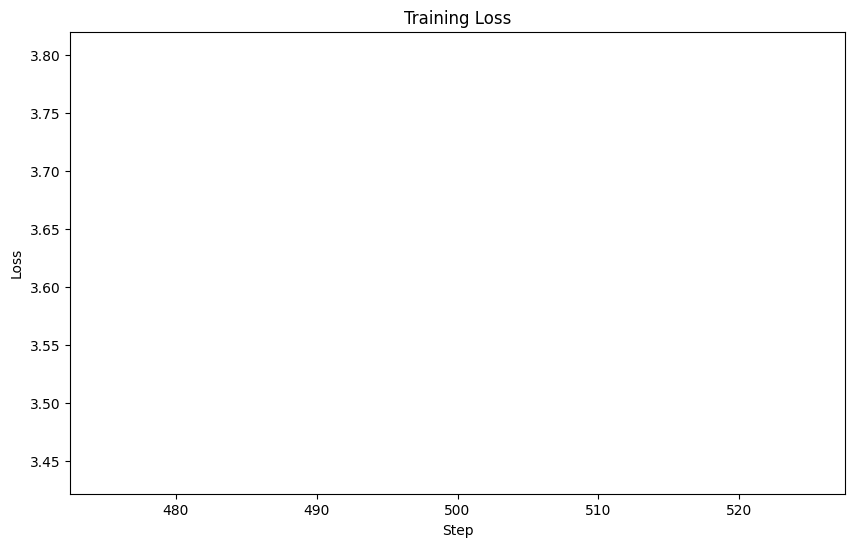

In [38]:
# Get the training loss
train_loss = trainer.state.log_history

# Extract loss values and steps
loss_values = [x['loss'] for x in train_loss if 'loss' in x]
step_values = [x['step'] for x in train_loss if 'loss' in x]

# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(step_values, loss_values)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()